In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/codas-project-for-stat-sig-test/clusters (4).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (15).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (3).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (9).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (10).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (7).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (14).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (1).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (11).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (2).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (6).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (8).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (12).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (13).csv
/kaggle/input/codas-project-for-stat-sig-test/clusters (5).csv
/kaggle/input/codas-project-for-stat-sig-test/see

In [2]:
# Cell 1: Import necessary library
import pandas as pd
import numpy as np
import glob
from scipy import stats
import matplotlib.pyplot as plt

# Cell 2: Load all CSV files from the specified directory
# This loads all the cluster CSV files from the 15 different runs
file_paths = glob.glob('/kaggle/input/codas-project-for-stat-sig-test/seeded/clusters_seeded*.csv')
dataframes = [pd.read_csv(file_path) for file_path in file_paths]
print(f"Successfully loaded {len(dataframes)} CSV files")

# Display the first few rows of the first dataframe to confirm structure
dataframes[0].head()

Successfully loaded 15 CSV files


,BS Name,KMeans,LSTM,GRU,TCN,voted,run_number,seed
0,A001,Residential,Residential,Residential,Residential,Residential,19,60
1,A002,Business/Industrial,Mixed,Mixed,Mixed,Mixed,19,60
2,A004,Residential,Residential,Residential,Residential,Residential,19,60
3,A005,Mixed,Residential,Residential,Residential,Residential,19,60
4,A006,Business/Industrial,Mixed,Mixed,Business/Industrial,Business/Industrial,19,60


In [3]:
# Cell 3: Extract unique base stations and categories
# Get all unique base station names and cluster categories that appear in the data
base_stations = dataframes[0]['BS Name'].unique()
categories = set()
for df in dataframes:
    for col in ['KMeans', 'LSTM', 'GRU', 'TCN']:
        categories.update(df[col].unique())
categories = list(categories)

print(f"Found {len(base_stations)} unique base stations")
print(f"Found {len(categories)} unique categories: {categories}")

Found 743 unique base stations
Found 3 unique categories: ['Mixed', 'Residential', 'Business/Industrial']


In [4]:
# Cell 4: Create co-occurrence matrices for each model
# This calculates how often each base station was classified into each category
# by each model across all 15 runs

model_results = {}
for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    model_results[model] = {bs: {cat: 0 for cat in categories} for bs in base_stations}
    
    # Count occurrences
    for df in dataframes:
        for _, row in df.iterrows():
            bs = row['BS Name']
            if bs in base_stations:  # Ensure BS exists in our list
                cat = row[model]
                model_results[model][bs][cat] += 1
    
    # Convert to probabilities
    for bs in base_stations:
        total = sum(model_results[model][bs].values())
        if total > 0:  # Avoid division by zero
            for cat in categories:
                model_results[model][bs][cat] /= total

# Display example of probabilities for one base station
example_bs = base_stations[0]
print(f"Classification probabilities for {example_bs}:")
for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    print(f"  {model}: {model_results[model][example_bs]}")

Classification probabilities for A001:
  KMeans: {'Mixed': 0.0, 'Residential': 1.0, 'Business/Industrial': 0.0}
  LSTM: {'Mixed': 0.6, 'Residential': 0.4, 'Business/Industrial': 0.0}
  GRU: {'Mixed': 0.2, 'Residential': 0.8, 'Business/Industrial': 0.0}
  TCN: {'Mixed': 0.5333333333333333, 'Residential': 0.4666666666666667, 'Business/Industrial': 0.0}


In [5]:
# Cell 5: Calculate confidence intervals using Wilson score interval
# This is a statistical significance test for proportions that works well
# even with small sample sizes or extreme proportions (near 0 or 1)

def wilson_conf_interval(count, n, confidence=0.95):
    """Calculate Wilson score confidence interval for a proportion."""
    if n == 0:
        return (0, 0)
    
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    p_hat = count / n
    
    # Wilson score interval formula
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2 * n)) / denominator
    half_width = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    return (max(0, center - half_width), min(1, center + half_width))

# Calculate confidence intervals for each model, base station, and category
confidence = 0.95
confidence_intervals = {model: {} for model in ['KMeans', 'LSTM', 'GRU', 'TCN']}

for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    for bs in base_stations:
        confidence_intervals[model][bs] = {}
        for cat in categories:
            p = model_results[model][bs][cat]
            n = len(dataframes)  # Number of runs (15)
            count = p * n
            
            # Wilson score interval
            interval = wilson_conf_interval(count, n, confidence)
            confidence_intervals[model][bs][cat] = interval

# Display example confidence intervals
print(f"95% confidence intervals for {example_bs} classifications:")
for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    print(f"  {model}:")
    for cat in categories:
        p = model_results[model][example_bs][cat]
        ci = confidence_intervals[model][example_bs][cat]
        if p > 0:  # Only show non-zero probabilities
            print(f"    {cat}: {p:.2f} ({ci[0]:.2f}, {ci[1]:.2f})")

95% confidence intervals for A001 classifications:
  KMeans:
    Residential: 1.00 (0.80, 1.00)
  LSTM:
    Mixed: 0.60 (0.36, 0.80)
    Residential: 0.40 (0.20, 0.64)
  GRU:
    Mixed: 0.20 (0.07, 0.45)
    Residential: 0.80 (0.55, 0.93)
  TCN:
    Mixed: 0.53 (0.30, 0.75)
    Residential: 0.47 (0.25, 0.70)


In [6]:
# Cell 5b: Bootstrap confidence intervals
# This calculates confidence intervals using bootstrapping resampling method

bootstrap_iterations = 1000
bootstrap_confidence_intervals = {model: {} for model in ['KMeans', 'LSTM', 'GRU', 'TCN']}

# First collect all classifications for each model and base station
model_classifications = {model: {bs: [] for bs in base_stations} for model in ['KMeans', 'LSTM', 'GRU', 'TCN']}

for df in dataframes:
    for _, row in df.iterrows():
        bs = row['BS Name']
        for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
            model_classifications[model][bs].append(row[model])

# Perform bootstrapping
for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    print(f"Bootstrapping {model}...")
    for bs in base_stations:
        classifications = model_classifications[model][bs]
        bootstrap_probs = {cat: [] for cat in categories}
        
        for _ in range(bootstrap_iterations):
            # Resample with replacement
            sample = np.random.choice(classifications, size=len(classifications), replace=True)
            # Calculate probabilities
            counts = {cat: 0 for cat in categories}
            for cls in sample:
                counts[cls] += 1
            total = len(sample)
            for cat in categories:
                prob = counts[cat]/total if total > 0 else 0
                bootstrap_probs[cat].append(prob)
                
        # Calculate confidence interval
        bootstrap_confidence_intervals[model][bs] = {}
        for cat in categories:
            if len(bootstrap_probs[cat]) > 0:
                lower = np.percentile(bootstrap_probs[cat], 2.5)
                upper = np.percentile(bootstrap_probs[cat], 97.5)
                bootstrap_confidence_intervals[model][bs][cat] = (lower, upper)
            else:
                bootstrap_confidence_intervals[model][bs][cat] = (0, 0)

# Compare bootstrap CI with Wilson CI for example base station
print("\nComparison for example base station:", example_bs)
for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    print(f"\n{model}:")
    for cat in categories:
        if model_results[model][example_bs][cat] > 0:
            wilson = confidence_intervals[model][example_bs][cat]
            bootstrap = bootstrap_confidence_intervals[model][example_bs][cat]
            print(f"  {cat}:")
            print(f"    Wilson: ({wilson[0]:.2f}, {wilson[1]:.2f})")
            print(f"    Bootstrap: ({bootstrap[0]:.2f}, {bootstrap[1]:.2f})")

Bootstrapping KMeans...
Bootstrapping LSTM...
Bootstrapping GRU...
Bootstrapping TCN...

Comparison for example base station: A001

KMeans:
  Residential:
    Wilson: (0.80, 1.00)
    Bootstrap: (1.00, 1.00)

LSTM:
  Mixed:
    Wilson: (0.36, 0.80)
    Bootstrap: (0.33, 0.87)
  Residential:
    Wilson: (0.20, 0.64)
    Bootstrap: (0.13, 0.67)

GRU:
  Mixed:
    Wilson: (0.07, 0.45)
    Bootstrap: (0.00, 0.40)
  Residential:
    Wilson: (0.55, 0.93)
    Bootstrap: (0.60, 1.00)

TCN:
  Mixed:
    Wilson: (0.30, 0.75)
    Bootstrap: (0.27, 0.80)
  Residential:
    Wilson: (0.25, 0.70)
    Bootstrap: (0.20, 0.73)


Model consistency scores (higher is better):
  KMeans: 0.6834
  LSTM: 0.6444
  GRU: 0.6305
  TCN: 0.6332


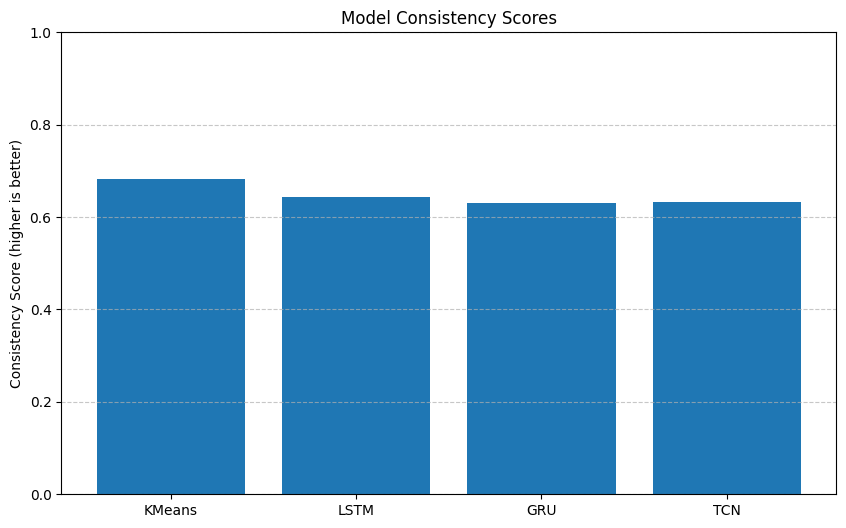

In [7]:
# Cell 6: Calculate model consistency scores
# This determines how consistent each model is across all runs
# by looking at the average width of confidence intervals (narrower is better)

model_consistency = {}
for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    interval_widths = []
    for bs in base_stations:
        for cat in categories:
            width = confidence_intervals[model][bs][cat][1] - confidence_intervals[model][bs][cat][0]
            # Only consider categories that were actually assigned
            if model_results[model][bs][cat] > 0:
                interval_widths.append(width)
    
    # A more consistent model will have narrower confidence intervals
    model_consistency[model] = 1 - np.mean(interval_widths)  # Higher is better

print("Model consistency scores (higher is better):")
for model, score in model_consistency.items():
    print(f"  {model}: {score:.4f}")

# Visualize model consistency
plt.figure(figsize=(10, 6))
plt.bar(model_consistency.keys(), model_consistency.values())
plt.title('Model Consistency Scores')
plt.ylabel('Consistency Score (higher is better)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_consistency.png')
plt.show()
plt.close()

In [8]:
# Cell 7: Fleiss' Kappa calculation for inter-model agreement
# This statistically measures whether the models agree with each other
# beyond what would be expected by chance

def calculate_fleiss_kappa(ratings):
    """
    Calculate Fleiss' Kappa for measuring inter-rater reliability.
    
    Parameters:
    ratings -- array of shape (n_subjects, n_raters) containing categories assigned by each rater
    
    Returns:
    kappa -- Fleiss' Kappa score
    """
    n_subjects = ratings.shape[0]
    n_raters = ratings.shape[1]
    n_categories = len(np.unique(ratings))
    
    # Count how many raters assigned each category to each subject
    category_counts = np.zeros((n_subjects, n_categories))
    for i in range(n_subjects):
        for j in range(n_raters):
            category = ratings[i, j]
            category_idx = np.where(np.unique(ratings) == category)[0][0]
            category_counts[i, category_idx] += 1
    
    # Calculate P_i (proportion of rater pairs that agree for subject i)
    P_i = np.sum(category_counts * (category_counts - 1), axis=1) / (n_raters * (n_raters - 1))
    P_bar = np.mean(P_i)  # Mean agreement across subjects
    
    # Calculate P_e (probability of chance agreement)
    P_j = np.sum(category_counts, axis=0) / (n_subjects * n_raters)
    P_e = np.sum(P_j ** 2)
    
    # Calculate kappa
    kappa = (P_bar - P_e) / (1 - P_e)
    
    return kappa

# Prepare the data for Fleiss' Kappa calculation
# For each run, create a matrix where rows are base stations and columns are models
all_runs_kappa = []

for df in dataframes:
    ratings = np.zeros((len(base_stations), 4))  # 4 models
    
    for i, bs in enumerate(base_stations):
        bs_data = df[df['BS Name'] == bs]
        if not bs_data.empty:
            ratings[i, 0] = categories.index(bs_data['KMeans'].values[0])
            ratings[i, 1] = categories.index(bs_data['LSTM'].values[0])
            ratings[i, 2] = categories.index(bs_data['GRU'].values[0])
            ratings[i, 3] = categories.index(bs_data['TCN'].values[0])
    
    kappa = calculate_fleiss_kappa(ratings)
    all_runs_kappa.append(kappa)

average_kappa = np.mean(all_runs_kappa)
print(f"Average Fleiss' Kappa across all runs: {average_kappa:.4f}")

# Interpret Kappa value
if average_kappa < 0:
    interpretation = "Poor agreement (less than chance)"
elif average_kappa < 0.2:
    interpretation = "Slight agreement"
elif average_kappa < 0.4:
    interpretation = "Fair agreement"
elif average_kappa < 0.6:
    interpretation = "Moderate agreement"
elif average_kappa < 0.8:
    interpretation = "Substantial agreement"
else:
    interpretation = "Almost perfect agreement"

print(f"Interpretation: {interpretation}")

Average Fleiss' Kappa across all runs: 0.4711
Interpretation: Moderate agreement


In [9]:
# Cell 8: Advanced voting scheme weighted by model consistency
# This creates a final classification for each base station by
# weighting each model's vote according to its overall consistency

final_classifications = {}
for bs in base_stations:
    scores = {cat: 0 for cat in categories}
    for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
        for cat in categories:
            # Weight by model consistency and probability of classification
            scores[cat] += model_consistency[model] * model_results[model][bs][cat]
    
    # Select category with highest weighted score
    final_classifications[bs] = max(scores, key=scores.get)

# Calculate confidence measures for each final classification
confidence_measures = []
for bs in base_stations:
    cat = final_classifications[bs]
    # Average confidence across models for the selected category
    conf = np.mean([model_results[model][bs][cat] for model in ['KMeans', 'LSTM', 'GRU', 'TCN']])
    confidence_measures.append(conf)

# Create final dataframe
final_df = pd.DataFrame({
    'BS Name': list(base_stations),
    'Final Cluster': [final_classifications[bs] for bs in base_stations],
    'Classification Confidence': confidence_measures
})

# Display the final classifications
print(f"Final classifications (showing first 10):")
final_df.head(10)

Final classifications (showing first 10):


,BS Name,Final Cluster,Classification Confidence
0,A001,Residential,0.666667
1,A002,Mixed,0.650000
2,A004,Residential,0.933333
3,A005,Residential,0.616667
4,A006,Business/Industrial,0.700000
5,A007,Residential,0.700000
6,A008,Residential,0.766667
7,A009,Residential,0.800000
8,A010,Business/Industrial,0.950000
9,A011,Residential,0.816667


In [10]:
# Cell 9: Analyze classification agreement/disagreement
# This analyzes how often each base station's classification differs 
# across runs and models

disagreement_counts = {}
for bs in base_stations:
    disagreement_counts[bs] = {
        'run_disagreement': 0,  # How often classification changes across runs
        'model_disagreement': 0  # How often models disagree within runs
    }
    
    # Check for model disagreement within each run
    for df in dataframes:
        bs_data = df[df['BS Name'] == bs]
        if not bs_data.empty:
            model_classifications = [
                bs_data['KMeans'].values[0],
                bs_data['LSTM'].values[0],
                bs_data['GRU'].values[0],
                bs_data['TCN'].values[0]
            ]
            # If not all models agree
            if len(set(model_classifications)) > 1:
                disagreement_counts[bs]['model_disagreement'] += 1
    
    # Check for run disagreement for each model
    for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
        classifications = []
        for df in dataframes:
            bs_data = df[df['BS Name'] == bs]
            if not bs_data.empty:
                classifications.append(bs_data[model].values[0])
        
        # If classification changes across runs
        if len(set(classifications)) > 1:
            disagreement_counts[bs]['run_disagreement'] += 1

# Add disagreement info to final dataframe
final_df['Model Disagreement'] = [disagreement_counts[bs]['model_disagreement']/len(dataframes) 
                                 for bs in base_stations]
final_df['Run Disagreement'] = [disagreement_counts[bs]['run_disagreement']/4  # 4 models
                               for bs in base_stations]

# Classify base stations by confidence level
def classify_confidence(row):
    if row['Classification Confidence'] > 0.8:
        return "High"
    elif row['Classification Confidence'] > 0.5:
        return "Medium"
    else:
        return "Low"

final_df['Confidence Level'] = final_df.apply(classify_confidence, axis=1)

# Display statistics about disagreement
print("Disagreement statistics:")
print(f"Base stations with high model disagreement (>75%): {sum(final_df['Model Disagreement'] > 0.75)}")
print(f"Base stations with high run disagreement (>75%): {sum(final_df['Run Disagreement'] > 0.75)}")
print(f"Base stations with high confidence: {sum(final_df['Confidence Level'] == 'High')}")
print(f"Base stations with medium confidence: {sum(final_df['Confidence Level'] == 'Medium')}")
print(f"Base stations with low confidence: {sum(final_df['Confidence Level'] == 'Low')}")

# Show updated dataframe with confidence levels
final_df.head(10)

Disagreement statistics:
Base stations with high model disagreement (>75%): 282
Base stations with high run disagreement (>75%): 215
Base stations with high confidence: 317
Base stations with medium confidence: 411
Base stations with low confidence: 15


,BS Name,Final Cluster,Classification Confidence,Model Disagreement,Run Disagreement,Confidence Level
0,A001,Residential,0.666667,0.933333,0.75,Medium
1,A002,Mixed,0.650000,0.733333,1.00,Medium
2,A004,Residential,0.933333,0.200000,0.50,High
3,A005,Residential,0.616667,0.800000,1.00,Medium
4,A006,Business/Industrial,0.700000,0.866667,0.75,Medium
5,A007,Residential,0.700000,0.733333,0.75,Medium
6,A008,Residential,0.766667,0.933333,0.50,Medium
7,A009,Residential,0.800000,0.600000,0.50,Medium
8,A010,Business/Industrial,0.950000,0.200000,0.50,High
9,A011,Residential,0.816667,0.666667,0.50,High


Final analysis saved to 'final_cluster_analysis.csv'

Distribution of final clusters:
Final Cluster
Residential            323
Mixed                  246
Business/Industrial    174
Name: count, dtype: int64


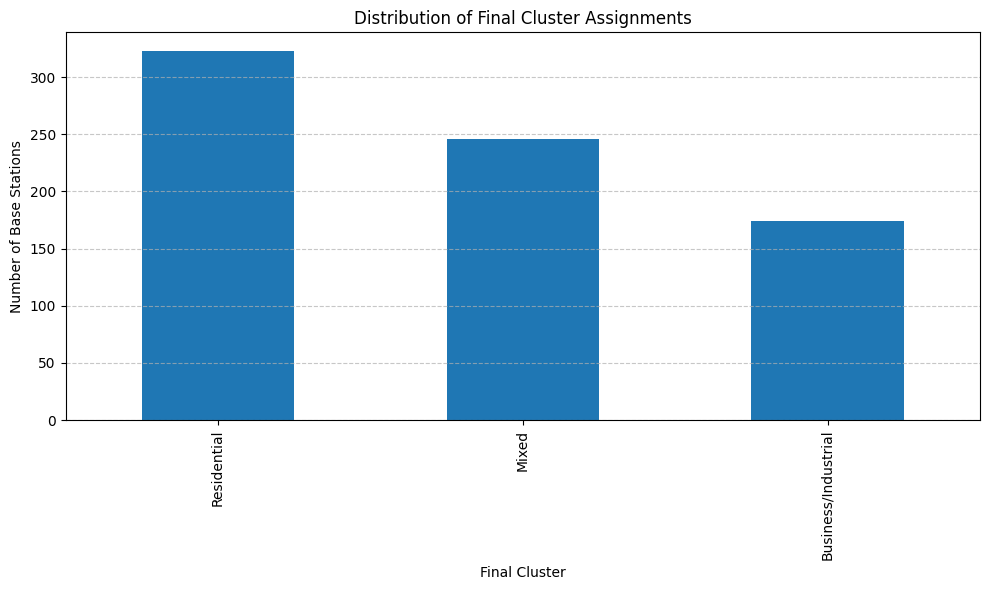

Cluster distribution visualization saved as 'cluster_distribution.png'


In [11]:
# Cell 10: Save the final results to a CSV file with detailed analysis
# This creates a comprehensive output with the final classifications
# and statistical measures of confidence

# Add additional information to final dataframe
for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    # Add the most common classification from each model
    final_df[f'{model} Most Common'] = [max(model_results[model][bs], key=model_results[model][bs].get) 
                                       for bs in base_stations]
    
    # Add the probability of the most common classification
    final_df[f'{model} Probability'] = [model_results[model][bs][final_df[f'{model} Most Common'][i]] 
                                       for i, bs in enumerate(base_stations)]

# Save the final results
final_df.to_csv('final_cluster_analysis.csv', index=False)
print("Final analysis saved to 'final_cluster_analysis.csv'")

# Display distribution of final clusters
cluster_counts = final_df['Final Cluster'].value_counts()
print("\nDistribution of final clusters:")
print(cluster_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.title('Distribution of Final Cluster Assignments')
plt.ylabel('Number of Base Stations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('cluster_distribution.png')
plt.show()
plt.close()

print("Cluster distribution visualization saved as 'cluster_distribution.png'")

In [12]:
import glob
import pandas as pd
import uuid

# Define the input directory and file pattern
input_dir = "/kaggle/input/codas-project-for-stat-sig-test/"
file_pattern = "clusters (*).csv"

# Load all CSV files
files = glob.glob(input_dir + file_pattern)

# Check if files were found
if not files:
    raise FileNotFoundError(f"No files matched the pattern {file_pattern} in {input_dir}")

# Initialize list to store processed DataFrames
dfs = []
for file in files:
    # Extract run number from filename, e.g., "clusters (4).csv" -> 4
    run_num = int(file.split('(')[1].split(')')[0])
    # Read CSV
    df = pd.read_csv(file)
    # Add run column
    df['run'] = run_num
    # Melt to long format, keeping only relevant columns
    melted = pd.melt(
        df,
        id_vars=['BS Name', 'run'],
        value_vars=['KMeans', 'LSTM', 'GRU', 'TCN'],
        var_name='model',
        value_name='cluster'
    )
    dfs.append(melted)

# Combine all DataFrames
all_data = pd.concat(dfs, ignore_index=True)

# Step 1: Count cluster occurrences per BS Name, model, and cluster
counts = all_data.groupby(['BS Name', 'model', 'cluster']).size().reset_index(name='count')

# Step 2: Find the mode cluster and its frequency for each BS Name and model
modes = counts.loc[counts.groupby(['BS Name', 'model'])['count'].idxmax()]
# modes now has: BS Name, model, cluster (mode), count (frequency)

# Step 3: Sum frequencies for each cluster per BS Name
cluster_sums = modes.groupby(['BS Name', 'cluster'])['count'].sum().reset_index()

# Step 4: Find the cluster with the maximum frequency sum per BS Name
final_clusters = cluster_sums.loc[cluster_sums.groupby('BS Name')['count'].idxmax()]
final_clusters = final_clusters[['BS Name', 'cluster']].rename(columns={'cluster': 'final_cluster'})

# Step 5: Save the final clustering to a CSV
output_file = '/kaggle/working/final_clusters.csv'
final_clusters.to_csv(output_file, index=False)

# Optional: Print confirmation
print(f"Final clustering saved to {output_file}")
print(final_clusters.head())

Final clustering saved to /kaggle/working/final_clusters.csv
  BS Name        final_cluster
1    A001          Residential
2    A002                Mixed
3    A004          Residential
4    A005          Residential
5    A006  Business/Industrial
